In [464]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline 


In [465]:
words = open('names.txt','r').read().splitlines() 


In [466]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [467]:
#building the dataset 

g = torch.Generator().manual_seed(2147483647)

block_size = 3 #contxt length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] #crops and appends 

X = torch.tensor(X)
Y = torch.tensor(Y)

In [468]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [469]:
#new way of building the dataset 

def build_dataset(words):
    block_size = 3 #context length: how many characters do we take to predict the next one>
    X,Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y 

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [485]:
C = torch.randn((27,2), generator=g) #fitting 27 characters into two 

In [471]:
C[5]

tensor([ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
        -0.9103, -0.7830])

In [472]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
        -0.9103, -0.7830])

In [473]:
#you can index with a list in python, also use tensors 
C[torch.tensor([5,6,7])]

tensor([[ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
         -0.9103, -0.7830],
        [ 0.1351, -0.2116, -1.0406, -1.5367,  0.9374, -0.8830,  1.7457,  2.1346,
         -0.8561,  0.5408],
        [ 0.6169,  1.5160, -1.0447, -0.6641, -0.7239,  1.7507,  0.1753,  0.9928,
         -0.6279,  0.0770]])

In [474]:
#so we will index using X since it can take multidimensional tensors 
print(C[X][13,2])
print(X[13,2])

tensor([-0.4713,  0.7868, -0.3284, -0.4330,  1.3729,  2.9334,  1.5618, -1.6261,
         0.6772, -0.8404])
tensor(1)


In [486]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [487]:
#creating the hidden layer 

W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g) 

In [477]:
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape

torch.Size([228146, 30])

In [488]:
torch.cat(torch.unbind(emb,1), 1).shape

torch.Size([228146, 6])

In [479]:
a = torch.arange(18)
a 


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [480]:
a.shape

torch.Size([18])

In [481]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [482]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [489]:
emb.view(emb.shape[0],6) == torch.cat(torch.unbind(emb,1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        ...,
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

In [ ]:
h = torch.tanh(emb.view(emb.shape[0], 6))@W1 + b1

tensor([[ 0.9993,  0.9997, -0.9254,  ...,  0.9980,  0.9794,  0.1367],
        [-0.9751,  1.0000,  0.9947,  ...,  0.1011,  0.9185, -0.2232],
        [ 0.9999, -0.1738, -0.9993,  ...,  0.9997,  1.0000,  0.9429],
        ...,
        [-0.9999,  0.9914,  0.9983,  ..., -0.5915,  0.8572, -0.9944],
        [-0.7956, -0.5842, -0.9973,  ...,  0.1429,  0.9964,  0.8657],
        [-0.9996, -0.8747,  0.9157,  ..., -0.9651, -0.7443, -0.5506]])

In [ ]:
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

torch.Size([228146, 27])

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts/counts.sum(1, keepdims=True)

In [ ]:
prob.shape 

torch.Size([228146, 27])

In [ ]:
#now we want to go through the prob tensor and pluck out the correct probability for the correct word in the y tensor that we want to predict 
prob[torch.arange(Y.shape[0]),Y]

tensor([7.3162e-06, 2.7559e-05, 3.6469e-21,  ..., 1.2097e-14, 1.9599e-15,
        7.8987e-14])

In [ ]:
loss = -prob[torch.arange(Y.shape[0]),Y].log().mean() 
loss 

tensor(26.0036)

In [ ]:
F.cross_entropy(logits, Y) #better version of calculating your own loss, more efficient backward pass

tensor(26.0036)

In [497]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn((200), generator=g)
W2 = torch.randn((200,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C, W1, b1, W2, b2] 

In [498]:

sum(p.nelement() for p in parameters) 

11897

In [499]:
for p in parameters:
    p.requires_grad = True 


In [500]:
lre = torch.linspace(-3,0,1000) 
lrs = 10**lre 

lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [501]:
lri = []
lossi=[] 

stepi = []

In [514]:


for i in range(50000):

    #minibatch construction: 
    ix = torch.randint(0,Xtr.shape[0], (32,))


    #forward pass 
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30)@W1+b1)
    logits = h@W2+b2 
    loss = F.cross_entropy(logits, Ytr[ix])

    #print(loss.item())

    

    #backward pass 
    for p in parameters: 
        p.grad = None 
    loss.backward()


    #update 
    lr = 0.1
    for p in parameters:
        p.data += -lr*p.grad 

    #track stats 
    # lri.append(lre[i])
    # lossi.append(loss.item())

    stepi.append(i)
    lossi.append(loss.log10().item())




        

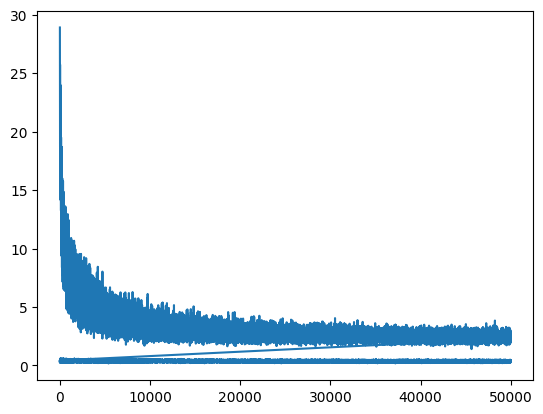

In [515]:
plt.plot(stepi, lossi)

In [516]:
print(loss.item())

2.113586664199829


In [517]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30)@W1+b1)
logits = h@W2+b2 
loss = F.cross_entropy(logits, Ytr)
loss 

tensor(2.3122, grad_fn=<NllLossBackward0>)

In [518]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30)@W1+b1)
logits = h@W2+b2 
loss = F.cross_entropy(logits, Ydev)
loss 

tensor(2.3358, grad_fn=<NllLossBackward0>)

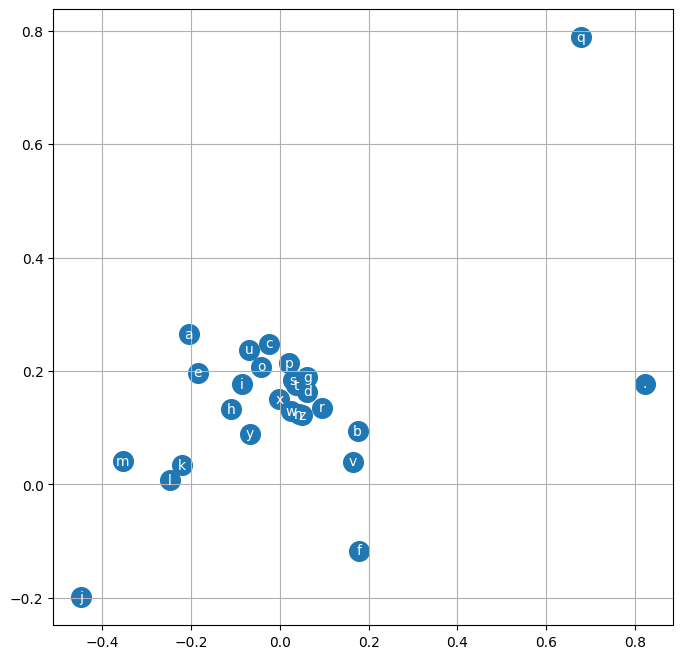

In [512]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i],ha="center",va="center", color="white")
plt.grid('minor')

In [ ]:
logits.max(1)

torch.return_types.max(
values=tensor([2.5289, 3.4535, 5.1350,  ..., 5.5292, 7.1877, 4.3968],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 12,  1,  ...,  1,  5, 14]))

In [ ]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [ ]:
#training split, dev/validation split, test split 
#80%, 10%, 10%

In [524]:
#sampling from the model

g = torch.Generator().manual_seed(2147483647) 

for _ in range(20):

    out = []
    context = [0]*block_size #initialize with all ...
    while True:
        emb = C[torch.tensor([context])] #(1,block_size,d)
        h = torch.tanh(emb.view(1,-1)@ W1 + b1)
        logits = h@W2 + b2 
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0 :
            break 

    print(''.join(itos[i] for i in out))


junide.
tana.
azha.
clayanina.
kei.
rito.
charaya.
thananaania.
daevias.
deyainraishansley.
cayla.
teriarauna.
taretumi.
phyn.
ten.
ruani.
cora.
yae.
gracy.
aari.
